# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# #  WandB Login and Configuration
# """
# 팀원 사용 가이드:

# 1. WandB 계정 생성: https://wandb.ai/signup
# 2. 이 셀 실행 시 로그인 프롬프트가 나타나면 개인 API 키 입력
# 3. EXPERIMENT_NAME을 다음과 같이 변경:
#    - "member1-baseline"
#    - "member2-augmentation-test"  
#    - "member3-hyperparameter-tuning"
#    등등 각자 다른 이름 사용

# 4. 팀 대시보드 URL: [여기에 당신의 프로젝트 URL 추가]

# 주의사항:
# - 절대 API 키를 코드에 하드코딩하지 마세요
# - EXPERIMENT_NAME만 변경하고 PROJECT_NAME은 그대로 두세요
# - 각자 개인 계정으로 로그인해서 실험을 추가하세요
# """

# # WandB 로그인 (각자 실행)
# try:
#     if wandb.api.api_key is None:
#         print("WandB에 로그인이 필요합니다.")
#         wandb.login()
#     else:
#         print(f"WandB 로그인 상태: {wandb.api.viewer()['username']}")
# except:
#     print("WandB 로그인을 진행합니다...")
#     wandb.login()

# # 프로젝트 설정 (각자 수정할 부분)
# PROJECT_NAME = "document-classification-team"  # 모든 팀원 동일
# ENTITY = None  # 각자 개인 계정 사용
# EXPERIMENT_NAME = "efficientnet-b3-baseline"  # 팀원별로 변경 (예: "member1-hyperopt", "member2-augmentation")

# print(f"프로젝트: {PROJECT_NAME}")
# print(f"실험명: {EXPERIMENT_NAME}")
# print("팀원들은 EXPERIMENT_NAME을 각자 다르게 변경해주세요!")

In [ ]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [6]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [7]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'

# training config
img_size = 384
LR = 2e-4
EPOCHS = 100
BATCH_SIZE = 24
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     # 비율 보존 리사이징 (핵심 개선)
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
    
#     # 문서 특화 회전 (정확한 90도 배수)
#     A.OneOf([
#         A.Rotate(limit=[90,90], p=1.0),
#         A.Rotate(limit=[180,180], p=1.0),
#         A.Rotate(limit=[270,270], p=1.0),
#     ], p=0.6),
    
#     # 테스트 특화 강화 증강
#     A.OneOf([
#         A.MotionBlur(blur_limit=7, p=1.0),
#         A.GaussianBlur(blur_limit=7, p=1.0),
#     ], p=0.9),
    
#     A.RandomBrightnessContrast(
#         brightness_limit=0.3, 
#         contrast_limit=0.3, 
#         p=0.8
#     ),
#     A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
#     A.HorizontalFlip(p=0.5),
    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [11]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [12]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.1467: 100%|██████████| 14/14 [00:04<00:00,  3.37it/s]

Epoch  1 | Train Loss: 2.0279 | Train F1: 0.3637 | Val Loss: 1.0530 | Val F1: 0.7214



Val Loss: 1.2502: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]

Epoch  2 | Train Loss: 1.1148 | Train F1: 0.6771 | Val Loss: 0.7502 | Val F1: 0.8053



Val Loss: 1.2779: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]

Epoch  3 | Train Loss: 0.9280 | Train F1: 0.7113 | Val Loss: 0.6686 | Val F1: 0.8565



Val Loss: 1.2349: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]


Epoch  4 | Train Loss: 0.9076 | Train F1: 0.7116 | Val Loss: 0.6577 | Val F1: 0.8561


Val Loss: 0.5682: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

Epoch  5 | Train Loss: 0.8555 | Train F1: 0.7614 | Val Loss: 0.5640 | Val F1: 0.8866



Val Loss: 0.5584: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch  6 | Train Loss: 0.7846 | Train F1: 0.7459 | Val Loss: 0.5833 | Val F1: 0.8549


Val Loss: 0.7450: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

Epoch  7 | Train Loss: 0.6946 | Train F1: 0.7472 | Val Loss: 0.5119 | Val F1: 0.9416



Val Loss: 1.0459: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch  8 | Train Loss: 0.7364 | Train F1: 0.8251 | Val Loss: 0.5888 | Val F1: 0.8782


Val Loss: 0.8679: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch  9 | Train Loss: 0.7868 | Train F1: 0.7901 | Val Loss: 0.5341 | Val F1: 0.9228


Val Loss: 0.4064: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 10 | Train Loss: 0.7354 | Train F1: 0.7799 | Val Loss: 0.5692 | Val F1: 0.8824


Val Loss: 0.7799: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 11 | Train Loss: 0.6840 | Train F1: 0.8234 | Val Loss: 0.5669 | Val F1: 0.8917


Val Loss: 1.3555: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 12 | Train Loss: 0.7983 | Train F1: 0.7093 | Val Loss: 0.5651 | Val F1: 0.9204


Val Loss: 0.7150: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

Epoch 13 | Train Loss: 0.7165 | Train F1: 0.7521 | Val Loss: 0.4997 | Val F1: 0.9425



Val Loss: 0.9020: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]


Epoch 14 | Train Loss: 0.6096 | Train F1: 0.8406 | Val Loss: 0.5240 | Val F1: 0.9214


Val Loss: 1.8105: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

Epoch 15 | Train Loss: 0.6031 | Train F1: 0.8792 | Val Loss: 0.5783 | Val F1: 0.9426



Val Loss: 1.0713: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 16 | Train Loss: 0.5352 | Train F1: 0.8869 | Val Loss: 0.5229 | Val F1: 0.9326


Val Loss: 0.5542: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 17 | Train Loss: 0.6397 | Train F1: 0.8246 | Val Loss: 0.5104 | Val F1: 0.9223


Val Loss: 0.6697: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]


Epoch 18 | Train Loss: 0.5701 | Train F1: 0.8754 | Val Loss: 0.4800 | Val F1: 0.9391


Val Loss: 0.3406: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 19 | Train Loss: 0.5827 | Train F1: 0.8852 | Val Loss: 0.5064 | Val F1: 0.9208


Val Loss: 0.9279: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 20 | Train Loss: 0.6492 | Train F1: 0.7827 | Val Loss: 0.5167 | Val F1: 0.9336


Val Loss: 0.3371: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 21 | Train Loss: 0.6072 | Train F1: 0.8490 | Val Loss: 0.5149 | Val F1: 0.9180


Val Loss: 0.3365: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]


Epoch 22 | Train Loss: 0.6656 | Train F1: 0.7881 | Val Loss: 0.5438 | Val F1: 0.9182


Val Loss: 0.4731: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]


Epoch 23 | Train Loss: 0.6102 | Train F1: 0.8155 | Val Loss: 0.4796 | Val F1: 0.9402


Val Loss: 0.3332: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

Epoch 24 | Train Loss: 0.5371 | Train F1: 0.8911 | Val Loss: 0.5026 | Val F1: 0.9428



Val Loss: 0.4391: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]

Epoch 25 | Train Loss: 0.5766 | Train F1: 0.8752 | Val Loss: 0.4667 | Val F1: 0.9429



Val Loss: 0.3293: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch 26 | Train Loss: 0.6172 | Train F1: 0.8249 | Val Loss: 0.4928 | Val F1: 0.9291


Val Loss: 0.3360: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 27 | Train Loss: 0.6307 | Train F1: 0.7453 | Val Loss: 0.5149 | Val F1: 0.9348


Val Loss: 0.3395: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

Epoch 28 | Train Loss: 0.5376 | Train F1: 0.9180 | Val Loss: 0.5011 | Val F1: 0.9431



Val Loss: 0.4297: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]

Epoch 29 | Train Loss: 0.5195 | Train F1: 0.8389 | Val Loss: 0.4447 | Val F1: 0.9602



Val Loss: 0.4049: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 30 | Train Loss: 0.5537 | Train F1: 0.8843 | Val Loss: 0.4676 | Val F1: 0.9391


Val Loss: 0.3361: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 31 | Train Loss: 0.5285 | Train F1: 0.8862 | Val Loss: 0.4925 | Val F1: 0.9462


Val Loss: 1.2712: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]


Epoch 32 | Train Loss: 0.5373 | Train F1: 0.8597 | Val Loss: 0.5389 | Val F1: 0.9492


Val Loss: 0.3261: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 33 | Train Loss: 0.5415 | Train F1: 0.8781 | Val Loss: 0.5192 | Val F1: 0.9221


Val Loss: 0.3276: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 34 | Train Loss: 0.6047 | Train F1: 0.8001 | Val Loss: 0.4921 | Val F1: 0.9334


Val Loss: 0.3252: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]


Epoch 35 | Train Loss: 0.5555 | Train F1: 0.8619 | Val Loss: 0.5031 | Val F1: 0.9256


Val Loss: 0.8064: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 36 | Train Loss: 0.5738 | Train F1: 0.7970 | Val Loss: 0.4497 | Val F1: 0.9503


Val Loss: 0.3250: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]


Epoch 37 | Train Loss: 0.5166 | Train F1: 0.9047 | Val Loss: 0.4914 | Val F1: 0.9363


Val Loss: 0.6306: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

Epoch 38 | Train Loss: 0.5568 | Train F1: 0.8545 | Val Loss: 0.4472 | Val F1: 0.9620



Val Loss: 0.4192: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]


Epoch 39 | Train Loss: 0.5335 | Train F1: 0.9126 | Val Loss: 0.4866 | Val F1: 0.9569


Val Loss: 0.3405: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 40 | Train Loss: 0.5004 | Train F1: 0.9105 | Val Loss: 0.4500 | Val F1: 0.9472


Val Loss: 1.2780: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 41 | Train Loss: 0.5728 | Train F1: 0.8530 | Val Loss: 0.4901 | Val F1: 0.9517


Val Loss: 0.3255: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]


Epoch 42 | Train Loss: 0.5164 | Train F1: 0.8367 | Val Loss: 0.4913 | Val F1: 0.9388


Val Loss: 0.3236: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]


Epoch 43 | Train Loss: 0.5367 | Train F1: 0.8513 | Val Loss: 0.4424 | Val F1: 0.9517


Val Loss: 0.6729: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 44 | Train Loss: 0.4364 | Train F1: 0.9110 | Val Loss: 0.4461 | Val F1: 0.9535


Val Loss: 0.3288: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 45 | Train Loss: 0.5385 | Train F1: 0.8689 | Val Loss: 0.4762 | Val F1: 0.9474


Val Loss: 0.3539: 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

Epoch 46 | Train Loss: 0.5292 | Train F1: 0.8657 | Val Loss: 0.4447 | Val F1: 0.9642



Val Loss: 1.9935: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 47 | Train Loss: 0.5640 | Train F1: 0.8732 | Val Loss: 0.5668 | Val F1: 0.9510


Val Loss: 0.3918: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

Epoch 48 | Train Loss: 0.4898 | Train F1: 0.9169 | Val Loss: 0.4154 | Val F1: 0.9675



Val Loss: 0.3246: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


Epoch 49 | Train Loss: 0.5775 | Train F1: 0.7892 | Val Loss: 0.4480 | Val F1: 0.9505


Val Loss: 0.3251: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]


Epoch 50 | Train Loss: 0.5188 | Train F1: 0.8614 | Val Loss: 0.4336 | Val F1: 0.9478


Val Loss: 0.3805: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]


Epoch 51 | Train Loss: 0.5091 | Train F1: 0.8927 | Val Loss: 0.4454 | Val F1: 0.9620


Val Loss: 0.3255: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]


Epoch 52 | Train Loss: 0.5652 | Train F1: 0.8468 | Val Loss: 0.4626 | Val F1: 0.9505


Val Loss: 1.3923: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 53 | Train Loss: 0.5626 | Train F1: 0.9031 | Val Loss: 0.5155 | Val F1: 0.9569


Val Loss: 0.3310: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]


Epoch 54 | Train Loss: 0.6171 | Train F1: 0.8284 | Val Loss: 0.4394 | Val F1: 0.9596


Val Loss: 0.3244: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 55 | Train Loss: 0.4825 | Train F1: 0.8593 | Val Loss: 0.4438 | Val F1: 0.9532


Val Loss: 0.3242: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 56 | Train Loss: 0.4907 | Train F1: 0.8487 | Val Loss: 0.4578 | Val F1: 0.9582


Val Loss: 0.3212: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 57 | Train Loss: 0.5982 | Train F1: 0.7847 | Val Loss: 0.4464 | Val F1: 0.9589


Val Loss: 0.3277: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 58 | Train Loss: 0.6259 | Train F1: 0.8215 | Val Loss: 0.4656 | Val F1: 0.9431


Val Loss: 0.4053: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

Epoch 59 | Train Loss: 0.4472 | Train F1: 0.9292 | Val Loss: 0.4151 | Val F1: 0.9704



Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 60 | Train Loss: 0.5613 | Train F1: 0.8477 | Val Loss: 0.4289 | Val F1: 0.9574


Val Loss: 0.3239: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]


Epoch 61 | Train Loss: 0.5230 | Train F1: 0.8690 | Val Loss: 0.4365 | Val F1: 0.9528


Val Loss: 0.3222: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 62 | Train Loss: 0.5224 | Train F1: 0.8837 | Val Loss: 0.4470 | Val F1: 0.9558


Val Loss: 0.6437: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]


Epoch 63 | Train Loss: 0.5335 | Train F1: 0.8394 | Val Loss: 0.4683 | Val F1: 0.9629


Val Loss: 0.3400: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 64 | Train Loss: 0.5248 | Train F1: 0.8706 | Val Loss: 0.4290 | Val F1: 0.9674


Val Loss: 0.3227: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 65 | Train Loss: 0.6490 | Train F1: 0.8307 | Val Loss: 0.4233 | Val F1: 0.9670


Val Loss: 0.3211: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 66 | Train Loss: 0.4995 | Train F1: 0.9184 | Val Loss: 0.4536 | Val F1: 0.9565


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 67 | Train Loss: 0.5569 | Train F1: 0.7977 | Val Loss: 0.4393 | Val F1: 0.9621


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 68 | Train Loss: 0.4643 | Train F1: 0.8876 | Val Loss: 0.4331 | Val F1: 0.9559


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 69 | Train Loss: 0.4980 | Train F1: 0.9012 | Val Loss: 0.4272 | Val F1: 0.9473


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 70 | Train Loss: 0.5346 | Train F1: 0.8299 | Val Loss: 0.4151 | Val F1: 0.9620


Val Loss: 0.3211: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 71 | Train Loss: 0.4956 | Train F1: 0.8911 | Val Loss: 0.4177 | Val F1: 0.9575


Val Loss: 0.4835: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 72 | Train Loss: 0.4859 | Train F1: 0.8742 | Val Loss: 0.4334 | Val F1: 0.9612


Val Loss: 0.3235: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 73 | Train Loss: 0.4896 | Train F1: 0.8851 | Val Loss: 0.4270 | Val F1: 0.9676


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 74 | Train Loss: 0.4931 | Train F1: 0.9069 | Val Loss: 0.4249 | Val F1: 0.9613


Val Loss: 0.3464: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 75 | Train Loss: 0.5758 | Train F1: 0.8323 | Val Loss: 0.4770 | Val F1: 0.9531


Val Loss: 0.3206: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]


Epoch 76 | Train Loss: 0.4917 | Train F1: 0.9060 | Val Loss: 0.4097 | Val F1: 0.9698


Val Loss: 0.3230: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

Epoch 77 | Train Loss: 0.5523 | Train F1: 0.8247 | Val Loss: 0.4070 | Val F1: 0.9747



Val Loss: 0.3236: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 78 | Train Loss: 0.5297 | Train F1: 0.8478 | Val Loss: 0.4113 | Val F1: 0.9727


Val Loss: 0.3225: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 79 | Train Loss: 0.5400 | Train F1: 0.8454 | Val Loss: 0.4194 | Val F1: 0.9662


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 80 | Train Loss: 0.5462 | Train F1: 0.8086 | Val Loss: 0.4143 | Val F1: 0.9632


Val Loss: 0.4100: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


Epoch 81 | Train Loss: 0.5278 | Train F1: 0.9019 | Val Loss: 0.4187 | Val F1: 0.9630


Val Loss: 0.3216: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 82 | Train Loss: 0.5148 | Train F1: 0.9131 | Val Loss: 0.4140 | Val F1: 0.9698


Val Loss: 0.3228: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 83 | Train Loss: 0.5615 | Train F1: 0.8425 | Val Loss: 0.4202 | Val F1: 0.9659


Val Loss: 0.3209: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]


Epoch 84 | Train Loss: 0.5301 | Train F1: 0.8812 | Val Loss: 0.4272 | Val F1: 0.9661


Val Loss: 0.3209: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]


Epoch 85 | Train Loss: 0.5891 | Train F1: 0.8097 | Val Loss: 0.4392 | Val F1: 0.9533


Val Loss: 0.3214: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 86 | Train Loss: 0.5232 | Train F1: 0.8587 | Val Loss: 0.4307 | Val F1: 0.9642


Val Loss: 0.3250: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 87 | Train Loss: 0.4811 | Train F1: 0.8586 | Val Loss: 0.4196 | Val F1: 0.9647


Val Loss: 0.3235: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 88 | Train Loss: 0.5203 | Train F1: 0.8943 | Val Loss: 0.4305 | Val F1: 0.9618


Val Loss: 0.3310: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 89 | Train Loss: 0.5482 | Train F1: 0.7932 | Val Loss: 0.4127 | Val F1: 0.9695


Val Loss: 0.3486: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 90 | Train Loss: 0.5423 | Train F1: 0.8483 | Val Loss: 0.4103 | Val F1: 0.9700


Val Loss: 0.3498: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 91 | Train Loss: 0.4991 | Train F1: 0.8820 | Val Loss: 0.4308 | Val F1: 0.9622


Val Loss: 0.4730: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 92 | Train Loss: 0.4586 | Train F1: 0.9026 | Val Loss: 0.4229 | Val F1: 0.9727


Val Loss: 0.3215: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 93 | Train Loss: 0.4474 | Train F1: 0.8888 | Val Loss: 0.4207 | Val F1: 0.9664


Val Loss: 0.3248: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 94 | Train Loss: 0.5891 | Train F1: 0.7987 | Val Loss: 0.4184 | Val F1: 0.9700


Val Loss: 0.3421: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]


Epoch 95 | Train Loss: 0.4699 | Train F1: 0.8888 | Val Loss: 0.4267 | Val F1: 0.9624


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 96 | Train Loss: 0.4429 | Train F1: 0.9512 | Val Loss: 0.4278 | Val F1: 0.9648


Val Loss: 0.3686: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


Epoch 97 | Train Loss: 0.5765 | Train F1: 0.8544 | Val Loss: 0.4328 | Val F1: 0.9586


Val Loss: 0.3284: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 98 | Train Loss: 0.4428 | Train F1: 0.8860 | Val Loss: 0.4363 | Val F1: 0.9607


Val Loss: 0.3207: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 99 | Train Loss: 0.4692 | Train F1: 0.8835 | Val Loss: 0.4379 | Val F1: 0.9642


Val Loss: 0.3230: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 100 | Train Loss: 0.4680 | Train F1: 0.8996 | Val Loss: 0.4216 | Val F1: 0.9677
Fold 1 Best Validation F1: 0.9747

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.9751: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]

Epoch  1 | Train Loss: 2.0375 | Train F1: 0.3464 | Val Loss: 1.1016 | Val F1: 0.6300



Val Loss: 1.1135: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]

Epoch  2 | Train Loss: 1.2537 | Train F1: 0.6077 | Val Loss: 0.7713 | Val F1: 0.8122



Val Loss: 0.9911: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

Epoch  3 | Train Loss: 1.0074 | Train F1: 0.6513 | Val Loss: 0.6993 | Val F1: 0.8310



Val Loss: 2.1420: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

Epoch  4 | Train Loss: 0.8511 | Train F1: 0.7732 | Val Loss: 0.7149 | Val F1: 0.8762



Val Loss: 0.7496: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch  5 | Train Loss: 0.8330 | Train F1: 0.7710 | Val Loss: 0.5625 | Val F1: 0.8619


Val Loss: 0.3544: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch  6 | Train Loss: 0.7262 | Train F1: 0.7982 | Val Loss: 0.5508 | Val F1: 0.8964



Val Loss: 0.6350: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch  7 | Train Loss: 0.8364 | Train F1: 0.7580 | Val Loss: 0.5511 | Val F1: 0.8842


Val Loss: 1.1819: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch  8 | Train Loss: 0.7850 | Train F1: 0.8113 | Val Loss: 0.6390 | Val F1: 0.8892


Val Loss: 0.6330: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

Epoch  9 | Train Loss: 0.7659 | Train F1: 0.7959 | Val Loss: 0.4816 | Val F1: 0.9377



Val Loss: 0.7501: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 10 | Train Loss: 0.7762 | Train F1: 0.7880 | Val Loss: 0.5162 | Val F1: 0.9249


Val Loss: 0.3885: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 11 | Train Loss: 0.7026 | Train F1: 0.8465 | Val Loss: 0.4945 | Val F1: 0.9356


Val Loss: 0.8700: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 12 | Train Loss: 0.6518 | Train F1: 0.8646 | Val Loss: 0.5088 | Val F1: 0.9160


Val Loss: 0.3540: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 13 | Train Loss: 0.6999 | Train F1: 0.8385 | Val Loss: 0.5167 | Val F1: 0.9185


Val Loss: 0.3676: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

Epoch 14 | Train Loss: 0.6604 | Train F1: 0.8348 | Val Loss: 0.4530 | Val F1: 0.9422



Val Loss: 0.8614: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch 15 | Train Loss: 0.7134 | Train F1: 0.8211 | Val Loss: 0.4752 | Val F1: 0.9437



Val Loss: 0.6275: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

Epoch 16 | Train Loss: 0.7045 | Train F1: 0.7792 | Val Loss: 0.4642 | Val F1: 0.9614



Val Loss: 0.5497: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 17 | Train Loss: 0.6284 | Train F1: 0.7930 | Val Loss: 0.4949 | Val F1: 0.9427


Val Loss: 0.4408: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 18 | Train Loss: 0.5679 | Train F1: 0.8836 | Val Loss: 0.4547 | Val F1: 0.9565


Val Loss: 0.3603: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 19 | Train Loss: 0.5736 | Train F1: 0.8746 | Val Loss: 0.4948 | Val F1: 0.9388


Val Loss: 0.3575: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 20 | Train Loss: 0.6449 | Train F1: 0.8278 | Val Loss: 0.4780 | Val F1: 0.9418


Val Loss: 0.3347: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 21 | Train Loss: 0.5499 | Train F1: 0.8880 | Val Loss: 0.4682 | Val F1: 0.9400


Val Loss: 0.4571: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

Epoch 22 | Train Loss: 0.5680 | Train F1: 0.8684 | Val Loss: 0.4441 | Val F1: 0.9690



Val Loss: 1.0913: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 23 | Train Loss: 0.5435 | Train F1: 0.8564 | Val Loss: 0.5086 | Val F1: 0.9483


Val Loss: 0.3712: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 24 | Train Loss: 0.6301 | Train F1: 0.8120 | Val Loss: 0.4995 | Val F1: 0.9345


Val Loss: 0.3431: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 25 | Train Loss: 0.5842 | Train F1: 0.8147 | Val Loss: 0.4481 | Val F1: 0.9511


Val Loss: 0.4863: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 26 | Train Loss: 0.5189 | Train F1: 0.8467 | Val Loss: 0.4569 | Val F1: 0.9575


Val Loss: 0.7666: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 27 | Train Loss: 0.6477 | Train F1: 0.8019 | Val Loss: 0.4789 | Val F1: 0.9523


Val Loss: 0.3373: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch 28 | Train Loss: 0.5679 | Train F1: 0.8406 | Val Loss: 0.4355 | Val F1: 0.9599


Val Loss: 1.3053: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 29 | Train Loss: 0.5423 | Train F1: 0.9341 | Val Loss: 0.5286 | Val F1: 0.9401


Val Loss: 0.8836: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch 30 | Train Loss: 0.6503 | Train F1: 0.8484 | Val Loss: 0.5294 | Val F1: 0.9363


Val Loss: 0.3387: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 31 | Train Loss: 0.5257 | Train F1: 0.8828 | Val Loss: 0.5143 | Val F1: 0.9563


Val Loss: 0.3514: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 32 | Train Loss: 0.5736 | Train F1: 0.8519 | Val Loss: 0.4478 | Val F1: 0.9490


Val Loss: 1.3781: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 33 | Train Loss: 0.5466 | Train F1: 0.8910 | Val Loss: 0.5137 | Val F1: 0.9574


Val Loss: 0.3349: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 34 | Train Loss: 0.4806 | Train F1: 0.8694 | Val Loss: 0.4578 | Val F1: 0.9654


Val Loss: 0.4155: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 35 | Train Loss: 0.5831 | Train F1: 0.7789 | Val Loss: 0.4623 | Val F1: 0.9606


Val Loss: 1.5035: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 36 | Train Loss: 0.5443 | Train F1: 0.8910 | Val Loss: 0.5336 | Val F1: 0.9520


Val Loss: 2.4306: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 37 | Train Loss: 0.5379 | Train F1: 0.8991 | Val Loss: 0.6208 | Val F1: 0.9529


Val Loss: 0.4060: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch 38 | Train Loss: 0.5554 | Train F1: 0.8115 | Val Loss: 0.4601 | Val F1: 0.9520


Val Loss: 1.1961: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 39 | Train Loss: 0.5604 | Train F1: 0.8673 | Val Loss: 0.5275 | Val F1: 0.9471


Val Loss: 0.5145: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 40 | Train Loss: 0.5459 | Train F1: 0.8727 | Val Loss: 0.4717 | Val F1: 0.9659


Val Loss: 1.4025: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 41 | Train Loss: 0.6001 | Train F1: 0.8018 | Val Loss: 0.5296 | Val F1: 0.9661


Val Loss: 1.5908: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 42 | Train Loss: 0.5261 | Train F1: 0.8721 | Val Loss: 0.5452 | Val F1: 0.9631


Val Loss: 0.3480: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 43 | Train Loss: 0.5044 | Train F1: 0.8516 | Val Loss: 0.4724 | Val F1: 0.9604


Val Loss: 0.3271: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 44 | Train Loss: 0.5264 | Train F1: 0.8908 | Val Loss: 0.4357 | Val F1: 0.9618


Val Loss: 0.3247: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 45 | Train Loss: 0.5479 | Train F1: 0.8240 | Val Loss: 0.4855 | Val F1: 0.9522


Val Loss: 1.0805: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch 46 | Train Loss: 0.6015 | Train F1: 0.8064 | Val Loss: 0.4998 | Val F1: 0.9661


Val Loss: 1.2910: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 47 | Train Loss: 0.5853 | Train F1: 0.8436 | Val Loss: 0.5475 | Val F1: 0.9577


Val Loss: 1.6034: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 48 | Train Loss: 0.5111 | Train F1: 0.8907 | Val Loss: 0.5368 | Val F1: 0.9534


Val Loss: 0.3336: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 49 | Train Loss: 0.5324 | Train F1: 0.8395 | Val Loss: 0.4459 | Val F1: 0.9607


Val Loss: 0.3220: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 50 | Train Loss: 0.5262 | Train F1: 0.8568 | Val Loss: 0.4608 | Val F1: 0.9553


Val Loss: 0.3245: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 51 | Train Loss: 0.5348 | Train F1: 0.8748 | Val Loss: 0.4373 | Val F1: 0.9641


Val Loss: 0.3237: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 52 | Train Loss: 0.4642 | Train F1: 0.8834 | Val Loss: 0.4469 | Val F1: 0.9656


Val Loss: 0.3251: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 53 | Train Loss: 0.5390 | Train F1: 0.8757 | Val Loss: 0.4082 | Val F1: 0.9762



Val Loss: 2.9233: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 54 | Train Loss: 0.4962 | Train F1: 0.8803 | Val Loss: 0.6444 | Val F1: 0.9521


Val Loss: 0.8037: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 55 | Train Loss: 0.4657 | Train F1: 0.9017 | Val Loss: 0.4650 | Val F1: 0.9661


Val Loss: 0.3637: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 56 | Train Loss: 0.5458 | Train F1: 0.8831 | Val Loss: 0.4626 | Val F1: 0.9515


Val Loss: 0.3260: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

Epoch 57 | Train Loss: 0.4834 | Train F1: 0.8751 | Val Loss: 0.4213 | Val F1: 0.9773



Val Loss: 0.3225: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 58 | Train Loss: 0.6388 | Train F1: 0.8389 | Val Loss: 0.4454 | Val F1: 0.9681


Val Loss: 1.7683: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 59 | Train Loss: 0.4855 | Train F1: 0.8495 | Val Loss: 0.5332 | Val F1: 0.9664


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 60 | Train Loss: 0.4679 | Train F1: 0.8810 | Val Loss: 0.4336 | Val F1: 0.9685


Val Loss: 0.8651: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 61 | Train Loss: 0.5315 | Train F1: 0.8284 | Val Loss: 0.4870 | Val F1: 0.9631


Val Loss: 1.0132: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 62 | Train Loss: 0.5187 | Train F1: 0.8836 | Val Loss: 0.4797 | Val F1: 0.9675


Val Loss: 1.2604: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 63 | Train Loss: 0.5096 | Train F1: 0.8503 | Val Loss: 0.4877 | Val F1: 0.9724


Val Loss: 1.5283: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]


Epoch 64 | Train Loss: 0.5332 | Train F1: 0.8820 | Val Loss: 0.5210 | Val F1: 0.9647


Val Loss: 2.3557: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 65 | Train Loss: 0.5351 | Train F1: 0.8332 | Val Loss: 0.5489 | Val F1: 0.9706


Val Loss: 0.3217: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 66 | Train Loss: 0.5924 | Train F1: 0.7931 | Val Loss: 0.4264 | Val F1: 0.9690


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 67 | Train Loss: 0.5339 | Train F1: 0.8861 | Val Loss: 0.4263 | Val F1: 0.9706


Val Loss: 2.4252: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 68 | Train Loss: 0.4697 | Train F1: 0.8395 | Val Loss: 0.5747 | Val F1: 0.9658


Val Loss: 2.0367: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]


Epoch 69 | Train Loss: 0.5608 | Train F1: 0.8328 | Val Loss: 0.5517 | Val F1: 0.9613


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]


Epoch 70 | Train Loss: 0.5453 | Train F1: 0.8452 | Val Loss: 0.4413 | Val F1: 0.9629


Val Loss: 0.3288: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 71 | Train Loss: 0.5317 | Train F1: 0.8280 | Val Loss: 0.4450 | Val F1: 0.9622


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch 72 | Train Loss: 0.5166 | Train F1: 0.8699 | Val Loss: 0.4323 | Val F1: 0.9662


Val Loss: 2.0205: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 73 | Train Loss: 0.4985 | Train F1: 0.8731 | Val Loss: 0.5661 | Val F1: 0.9633


Val Loss: 0.3233: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 74 | Train Loss: 0.4740 | Train F1: 0.8663 | Val Loss: 0.4648 | Val F1: 0.9576


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 75 | Train Loss: 0.5131 | Train F1: 0.9023 | Val Loss: 0.4550 | Val F1: 0.9651


Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 76 | Train Loss: 0.5167 | Train F1: 0.8565 | Val Loss: 0.4195 | Val F1: 0.9704


Val Loss: 1.9159: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 77 | Train Loss: 0.5231 | Train F1: 0.8276 | Val Loss: 0.5404 | Val F1: 0.9648


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 78 | Train Loss: 0.4832 | Train F1: 0.9066 | Val Loss: 0.4414 | Val F1: 0.9660


Val Loss: 0.3261: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 79 | Train Loss: 0.5081 | Train F1: 0.8364 | Val Loss: 0.4254 | Val F1: 0.9751


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 80 | Train Loss: 0.5534 | Train F1: 0.7889 | Val Loss: 0.4157 | Val F1: 0.9719


Val Loss: 0.3215: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 81 | Train Loss: 0.6011 | Train F1: 0.7558 | Val Loss: 0.4314 | Val F1: 0.9667


Val Loss: 2.3934: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 82 | Train Loss: 0.5396 | Train F1: 0.9095 | Val Loss: 0.5552 | Val F1: 0.9719


Val Loss: 0.3210: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 83 | Train Loss: 0.4457 | Train F1: 0.8823 | Val Loss: 0.4172 | Val F1: 0.9754


Val Loss: 0.3492: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 84 | Train Loss: 0.5449 | Train F1: 0.7781 | Val Loss: 0.4152 | Val F1: 0.9763


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 85 | Train Loss: 0.4968 | Train F1: 0.8583 | Val Loss: 0.4601 | Val F1: 0.9603


Val Loss: 1.8123: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 86 | Train Loss: 0.4829 | Train F1: 0.8569 | Val Loss: 0.5490 | Val F1: 0.9589


Val Loss: 0.6222: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 87 | Train Loss: 0.4823 | Train F1: 0.9086 | Val Loss: 0.4645 | Val F1: 0.9661


Val Loss: 2.0319: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 88 | Train Loss: 0.5509 | Train F1: 0.8118 | Val Loss: 0.5483 | Val F1: 0.9617


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 89 | Train Loss: 0.5604 | Train F1: 0.8348 | Val Loss: 0.4262 | Val F1: 0.9705


Val Loss: 0.9970: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]


Epoch 90 | Train Loss: 0.5281 | Train F1: 0.8304 | Val Loss: 0.4542 | Val F1: 0.9754


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 91 | Train Loss: 0.5243 | Train F1: 0.8697 | Val Loss: 0.4301 | Val F1: 0.9747


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 92 | Train Loss: 0.4657 | Train F1: 0.9007 | Val Loss: 0.4419 | Val F1: 0.9604


Val Loss: 1.4243: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 93 | Train Loss: 0.5397 | Train F1: 0.9052 | Val Loss: 0.5149 | Val F1: 0.9612


Val Loss: 1.4434: 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch 94 | Train Loss: 0.4829 | Train F1: 0.8379 | Val Loss: 0.4866 | Val F1: 0.9691


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 95 | Train Loss: 0.5275 | Train F1: 0.8629 | Val Loss: 0.4327 | Val F1: 0.9662


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 96 | Train Loss: 0.5272 | Train F1: 0.8450 | Val Loss: 0.4457 | Val F1: 0.9690


Val Loss: 0.7060: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 97 | Train Loss: 0.5194 | Train F1: 0.8837 | Val Loss: 0.4676 | Val F1: 0.9584


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 98 | Train Loss: 0.5324 | Train F1: 0.8291 | Val Loss: 0.4164 | Val F1: 0.9699


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch 99 | Train Loss: 0.5284 | Train F1: 0.8673 | Val Loss: 0.4206 | Val F1: 0.9747


Val Loss: 0.3801: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 100 | Train Loss: 0.5533 | Train F1: 0.8600 | Val Loss: 0.4500 | Val F1: 0.9674
Fold 2 Best Validation F1: 0.9773

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3545: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

Epoch  1 | Train Loss: 1.9279 | Train F1: 0.3887 | Val Loss: 0.9482 | Val F1: 0.7624



Val Loss: 0.3408: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

Epoch  2 | Train Loss: 1.2375 | Train F1: 0.6371 | Val Loss: 0.7483 | Val F1: 0.7995



Val Loss: 0.3419: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

Epoch  3 | Train Loss: 0.8771 | Train F1: 0.7767 | Val Loss: 0.6214 | Val F1: 0.8452



Val Loss: 0.3484: 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

Epoch  4 | Train Loss: 0.9507 | Train F1: 0.7469 | Val Loss: 0.5592 | Val F1: 0.8620



Val Loss: 0.3316: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]


Epoch  5 | Train Loss: 0.8854 | Train F1: 0.7646 | Val Loss: 0.5535 | Val F1: 0.8475


Val Loss: 0.3289: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

Epoch  6 | Train Loss: 0.8342 | Train F1: 0.7610 | Val Loss: 0.5382 | Val F1: 0.8710



Val Loss: 0.3305: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

Epoch  7 | Train Loss: 0.7741 | Train F1: 0.8181 | Val Loss: 0.5368 | Val F1: 0.8806



Val Loss: 0.3262: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

Epoch  8 | Train Loss: 0.6842 | Train F1: 0.8171 | Val Loss: 0.4955 | Val F1: 0.9125



Val Loss: 0.3325: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch  9 | Train Loss: 0.6241 | Train F1: 0.8609 | Val Loss: 0.5172 | Val F1: 0.8884


Val Loss: 0.3444: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

Epoch 10 | Train Loss: 0.7322 | Train F1: 0.8038 | Val Loss: 0.5060 | Val F1: 0.9215



Val Loss: 0.3391: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch 11 | Train Loss: 0.6601 | Train F1: 0.8209 | Val Loss: 0.4509 | Val F1: 0.9295



Val Loss: 0.3284: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

Epoch 12 | Train Loss: 0.6617 | Train F1: 0.8686 | Val Loss: 0.4750 | Val F1: 0.9438



Val Loss: 0.3258: 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


Epoch 13 | Train Loss: 0.6642 | Train F1: 0.8159 | Val Loss: 0.4848 | Val F1: 0.9292


Val Loss: 0.3292: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 14 | Train Loss: 0.6949 | Train F1: 0.8272 | Val Loss: 0.4904 | Val F1: 0.9267


Val Loss: 0.3272: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 15 | Train Loss: 0.6818 | Train F1: 0.7940 | Val Loss: 0.4415 | Val F1: 0.9491



Val Loss: 0.3277: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 16 | Train Loss: 0.6983 | Train F1: 0.7793 | Val Loss: 0.4590 | Val F1: 0.9445


Val Loss: 0.3364: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 17 | Train Loss: 0.5987 | Train F1: 0.8441 | Val Loss: 0.4576 | Val F1: 0.9382


Val Loss: 0.3257: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

Epoch 18 | Train Loss: 0.6162 | Train F1: 0.8128 | Val Loss: 0.4232 | Val F1: 0.9650



Val Loss: 0.3364: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 19 | Train Loss: 0.6637 | Train F1: 0.7888 | Val Loss: 0.4867 | Val F1: 0.9209


Val Loss: 0.3280: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 20 | Train Loss: 0.5962 | Train F1: 0.9177 | Val Loss: 0.4318 | Val F1: 0.9573


Val Loss: 0.3244: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 21 | Train Loss: 0.6441 | Train F1: 0.8509 | Val Loss: 0.4897 | Val F1: 0.9330


Val Loss: 0.3259: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 22 | Train Loss: 0.6828 | Train F1: 0.8574 | Val Loss: 0.4617 | Val F1: 0.9351


Val Loss: 0.3257: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 23 | Train Loss: 0.6513 | Train F1: 0.8396 | Val Loss: 0.5068 | Val F1: 0.9318


Val Loss: 0.3260: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 24 | Train Loss: 0.5873 | Train F1: 0.8826 | Val Loss: 0.4437 | Val F1: 0.9526


Val Loss: 0.3230: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 25 | Train Loss: 0.6071 | Train F1: 0.8310 | Val Loss: 0.4900 | Val F1: 0.9394


Val Loss: 0.3222: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 26 | Train Loss: 0.5846 | Train F1: 0.8575 | Val Loss: 0.4972 | Val F1: 0.9322


Val Loss: 0.3242: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 27 | Train Loss: 0.5080 | Train F1: 0.9128 | Val Loss: 0.4803 | Val F1: 0.9290


Val Loss: 0.3226: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 28 | Train Loss: 0.5074 | Train F1: 0.9277 | Val Loss: 0.4674 | Val F1: 0.9383


Val Loss: 0.3255: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 29 | Train Loss: 0.5688 | Train F1: 0.8449 | Val Loss: 0.4621 | Val F1: 0.9464


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 30 | Train Loss: 0.4594 | Train F1: 0.8916 | Val Loss: 0.4225 | Val F1: 0.9563


Val Loss: 0.3217: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 31 | Train Loss: 0.5894 | Train F1: 0.8592 | Val Loss: 0.4334 | Val F1: 0.9589


Val Loss: 0.3217: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch 32 | Train Loss: 0.5255 | Train F1: 0.8815 | Val Loss: 0.4024 | Val F1: 0.9716



Val Loss: 0.3241: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch 33 | Train Loss: 0.5038 | Train F1: 0.8547 | Val Loss: 0.3929 | Val F1: 0.9730



Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 34 | Train Loss: 0.5449 | Train F1: 0.8734 | Val Loss: 0.4368 | Val F1: 0.9570


Val Loss: 0.3222: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 35 | Train Loss: 0.6446 | Train F1: 0.7806 | Val Loss: 0.4784 | Val F1: 0.9469


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 36 | Train Loss: 0.5522 | Train F1: 0.8934 | Val Loss: 0.4804 | Val F1: 0.9464


Val Loss: 0.3224: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 37 | Train Loss: 0.5795 | Train F1: 0.8470 | Val Loss: 0.4678 | Val F1: 0.9469


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 38 | Train Loss: 0.5625 | Train F1: 0.8599 | Val Loss: 0.4471 | Val F1: 0.9477


Val Loss: 0.3212: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 39 | Train Loss: 0.5476 | Train F1: 0.8710 | Val Loss: 0.4418 | Val F1: 0.9562


Val Loss: 0.3215: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 40 | Train Loss: 0.5442 | Train F1: 0.8097 | Val Loss: 0.4482 | Val F1: 0.9531


Val Loss: 0.3210: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 41 | Train Loss: 0.6198 | Train F1: 0.8208 | Val Loss: 0.4204 | Val F1: 0.9532


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 42 | Train Loss: 0.5649 | Train F1: 0.8432 | Val Loss: 0.4698 | Val F1: 0.9422


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 43 | Train Loss: 0.5556 | Train F1: 0.7854 | Val Loss: 0.4413 | Val F1: 0.9520


Val Loss: 0.3230: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 44 | Train Loss: 0.5619 | Train F1: 0.8434 | Val Loss: 0.4192 | Val F1: 0.9701


Val Loss: 0.3231: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 45 | Train Loss: 0.5898 | Train F1: 0.8391 | Val Loss: 0.4242 | Val F1: 0.9638


Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 46 | Train Loss: 0.5824 | Train F1: 0.8054 | Val Loss: 0.4491 | Val F1: 0.9428


Val Loss: 0.3226: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 47 | Train Loss: 0.5185 | Train F1: 0.8205 | Val Loss: 0.4681 | Val F1: 0.9418


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 48 | Train Loss: 0.5249 | Train F1: 0.8743 | Val Loss: 0.4726 | Val F1: 0.9485


Val Loss: 0.3208: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 49 | Train Loss: 0.4100 | Train F1: 0.9318 | Val Loss: 0.4297 | Val F1: 0.9584


Val Loss: 0.3217: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 50 | Train Loss: 0.5197 | Train F1: 0.8673 | Val Loss: 0.4324 | Val F1: 0.9549


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]


Epoch 51 | Train Loss: 0.5423 | Train F1: 0.8472 | Val Loss: 0.4257 | Val F1: 0.9640


Val Loss: 0.3209: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 52 | Train Loss: 0.5626 | Train F1: 0.8948 | Val Loss: 0.4298 | Val F1: 0.9611


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 53 | Train Loss: 0.5215 | Train F1: 0.8534 | Val Loss: 0.4378 | Val F1: 0.9496


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 54 | Train Loss: 0.5058 | Train F1: 0.8978 | Val Loss: 0.4617 | Val F1: 0.9545


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 55 | Train Loss: 0.5426 | Train F1: 0.8387 | Val Loss: 0.4188 | Val F1: 0.9586


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 56 | Train Loss: 0.5889 | Train F1: 0.7919 | Val Loss: 0.4044 | Val F1: 0.9674


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 57 | Train Loss: 0.4789 | Train F1: 0.9009 | Val Loss: 0.4144 | Val F1: 0.9673


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 58 | Train Loss: 0.5562 | Train F1: 0.8311 | Val Loss: 0.4175 | Val F1: 0.9680


Val Loss: 0.3207: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]


Epoch 59 | Train Loss: 0.5468 | Train F1: 0.8945 | Val Loss: 0.4296 | Val F1: 0.9593


Val Loss: 0.3210: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 60 | Train Loss: 0.5138 | Train F1: 0.8517 | Val Loss: 0.4197 | Val F1: 0.9644


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch 61 | Train Loss: 0.5238 | Train F1: 0.8508 | Val Loss: 0.4332 | Val F1: 0.9563


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 62 | Train Loss: 0.5030 | Train F1: 0.8585 | Val Loss: 0.4278 | Val F1: 0.9639


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 63 | Train Loss: 0.5503 | Train F1: 0.7954 | Val Loss: 0.4167 | Val F1: 0.9565


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 64 | Train Loss: 0.5700 | Train F1: 0.7834 | Val Loss: 0.4483 | Val F1: 0.9499


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 65 | Train Loss: 0.4249 | Train F1: 0.9297 | Val Loss: 0.4659 | Val F1: 0.9528


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 66 | Train Loss: 0.5132 | Train F1: 0.8115 | Val Loss: 0.4123 | Val F1: 0.9607


Val Loss: 0.3205: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 67 | Train Loss: 0.5035 | Train F1: 0.8949 | Val Loss: 0.4292 | Val F1: 0.9543


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 68 | Train Loss: 0.5388 | Train F1: 0.8644 | Val Loss: 0.4372 | Val F1: 0.9524


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 69 | Train Loss: 0.5316 | Train F1: 0.8513 | Val Loss: 0.4238 | Val F1: 0.9569


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 70 | Train Loss: 0.5225 | Train F1: 0.8496 | Val Loss: 0.4122 | Val F1: 0.9673


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 71 | Train Loss: 0.5465 | Train F1: 0.8462 | Val Loss: 0.4303 | Val F1: 0.9548


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 72 | Train Loss: 0.5026 | Train F1: 0.8787 | Val Loss: 0.4280 | Val F1: 0.9541


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 73 | Train Loss: 0.4928 | Train F1: 0.9094 | Val Loss: 0.4419 | Val F1: 0.9577


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 74 | Train Loss: 0.5839 | Train F1: 0.8473 | Val Loss: 0.4264 | Val F1: 0.9595


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 75 | Train Loss: 0.5162 | Train F1: 0.8039 | Val Loss: 0.4096 | Val F1: 0.9698


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 76 | Train Loss: 0.5354 | Train F1: 0.8014 | Val Loss: 0.4326 | Val F1: 0.9476


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]


Epoch 77 | Train Loss: 0.5544 | Train F1: 0.8434 | Val Loss: 0.4408 | Val F1: 0.9590


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 78 | Train Loss: 0.5195 | Train F1: 0.8387 | Val Loss: 0.4215 | Val F1: 0.9651


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 79 | Train Loss: 0.4996 | Train F1: 0.8948 | Val Loss: 0.4130 | Val F1: 0.9578


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 80 | Train Loss: 0.5447 | Train F1: 0.8089 | Val Loss: 0.4539 | Val F1: 0.9451


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.67it/s]


Epoch 81 | Train Loss: 0.5141 | Train F1: 0.8096 | Val Loss: 0.4245 | Val F1: 0.9567


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch 82 | Train Loss: 0.4960 | Train F1: 0.8876 | Val Loss: 0.4289 | Val F1: 0.9583


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 83 | Train Loss: 0.4587 | Train F1: 0.9051 | Val Loss: 0.4231 | Val F1: 0.9612


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 84 | Train Loss: 0.4281 | Train F1: 0.8944 | Val Loss: 0.4418 | Val F1: 0.9544


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 85 | Train Loss: 0.5950 | Train F1: 0.7948 | Val Loss: 0.4353 | Val F1: 0.9508


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 86 | Train Loss: 0.4881 | Train F1: 0.8932 | Val Loss: 0.4293 | Val F1: 0.9614


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 87 | Train Loss: 0.4604 | Train F1: 0.9089 | Val Loss: 0.4320 | Val F1: 0.9590


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 88 | Train Loss: 0.4686 | Train F1: 0.8496 | Val Loss: 0.4229 | Val F1: 0.9673


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 89 | Train Loss: 0.4911 | Train F1: 0.8785 | Val Loss: 0.4456 | Val F1: 0.9595


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 90 | Train Loss: 0.4808 | Train F1: 0.9186 | Val Loss: 0.3845 | Val F1: 0.9701


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch 91 | Train Loss: 0.5089 | Train F1: 0.8190 | Val Loss: 0.4517 | Val F1: 0.9504


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 92 | Train Loss: 0.5333 | Train F1: 0.7927 | Val Loss: 0.4121 | Val F1: 0.9596


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 93 | Train Loss: 0.4863 | Train F1: 0.9012 | Val Loss: 0.4342 | Val F1: 0.9673


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 94 | Train Loss: 0.5506 | Train F1: 0.8390 | Val Loss: 0.4313 | Val F1: 0.9508


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 95 | Train Loss: 0.4415 | Train F1: 0.9060 | Val Loss: 0.4254 | Val F1: 0.9701


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 96 | Train Loss: 0.5564 | Train F1: 0.8305 | Val Loss: 0.4370 | Val F1: 0.9671


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 97 | Train Loss: 0.4990 | Train F1: 0.8308 | Val Loss: 0.4466 | Val F1: 0.9518


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 98 | Train Loss: 0.5894 | Train F1: 0.7881 | Val Loss: 0.4262 | Val F1: 0.9620


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 99 | Train Loss: 0.5386 | Train F1: 0.7787 | Val Loss: 0.4300 | Val F1: 0.9563


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 100 | Train Loss: 0.5332 | Train F1: 0.8250 | Val Loss: 0.4363 | Val F1: 0.9560
Fold 3 Best Validation F1: 0.9730

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3755: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch  1 | Train Loss: 1.8626 | Train F1: 0.4234 | Val Loss: 0.8664 | Val F1: 0.7692



Val Loss: 0.3365: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

Epoch  2 | Train Loss: 1.0593 | Train F1: 0.6772 | Val Loss: 0.7395 | Val F1: 0.7922



Val Loss: 0.3328: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

Epoch  3 | Train Loss: 0.9631 | Train F1: 0.7110 | Val Loss: 0.5785 | Val F1: 0.8962



Val Loss: 0.3317: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch  4 | Train Loss: 0.8291 | Train F1: 0.7979 | Val Loss: 0.5843 | Val F1: 0.8460


Val Loss: 0.3331: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch  5 | Train Loss: 0.7597 | Train F1: 0.7814 | Val Loss: 0.5469 | Val F1: 0.8816


Val Loss: 0.3314: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch  6 | Train Loss: 0.7786 | Train F1: 0.8209 | Val Loss: 0.5553 | Val F1: 0.8886


Val Loss: 0.3277: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch  7 | Train Loss: 0.8054 | Train F1: 0.6877 | Val Loss: 0.5551 | Val F1: 0.8806


Val Loss: 0.3319: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch  8 | Train Loss: 0.7276 | Train F1: 0.8033 | Val Loss: 0.5868 | Val F1: 0.8816


Val Loss: 0.3273: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch  9 | Train Loss: 0.7740 | Train F1: 0.8169 | Val Loss: 0.5176 | Val F1: 0.9202



Val Loss: 0.3305: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch 10 | Train Loss: 0.6905 | Train F1: 0.8547 | Val Loss: 0.5236 | Val F1: 0.9211



Val Loss: 0.3675: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 11 | Train Loss: 0.6522 | Train F1: 0.8706 | Val Loss: 0.4918 | Val F1: 0.9080


Val Loss: 0.3269: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 12 | Train Loss: 0.6740 | Train F1: 0.8023 | Val Loss: 0.5203 | Val F1: 0.9069


Val Loss: 0.3342: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch 13 | Train Loss: 0.6928 | Train F1: 0.8026 | Val Loss: 0.5119 | Val F1: 0.9127


Val Loss: 0.3332: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

Epoch 14 | Train Loss: 0.7025 | Train F1: 0.8360 | Val Loss: 0.4674 | Val F1: 0.9312



Val Loss: 0.3311: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 15 | Train Loss: 0.6727 | Train F1: 0.8306 | Val Loss: 0.4884 | Val F1: 0.9311


Val Loss: 0.3245: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 16 | Train Loss: 0.6385 | Train F1: 0.8767 | Val Loss: 0.5445 | Val F1: 0.8865


Val Loss: 0.3244: 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

Epoch 17 | Train Loss: 0.6603 | Train F1: 0.8201 | Val Loss: 0.4933 | Val F1: 0.9349



Val Loss: 0.3229: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 18 | Train Loss: 0.6678 | Train F1: 0.8407 | Val Loss: 0.4905 | Val F1: 0.9210


Val Loss: 0.3284: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 19 | Train Loss: 0.6219 | Train F1: 0.8394 | Val Loss: 0.4876 | Val F1: 0.9345


Val Loss: 0.3256: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch 20 | Train Loss: 0.6368 | Train F1: 0.8817 | Val Loss: 0.4819 | Val F1: 0.9396



Val Loss: 0.3274: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch 21 | Train Loss: 0.6696 | Train F1: 0.8438 | Val Loss: 0.4833 | Val F1: 0.9412



Val Loss: 0.3250: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 22 | Train Loss: 0.5562 | Train F1: 0.9021 | Val Loss: 0.4854 | Val F1: 0.9351


Val Loss: 0.3316: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 23 | Train Loss: 0.6410 | Train F1: 0.8154 | Val Loss: 0.4855 | Val F1: 0.9311


Val Loss: 0.3231: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 24 | Train Loss: 0.6391 | Train F1: 0.8554 | Val Loss: 0.4723 | Val F1: 0.9368


Val Loss: 0.3228: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

Epoch 25 | Train Loss: 0.5437 | Train F1: 0.8430 | Val Loss: 0.4902 | Val F1: 0.9458



Val Loss: 0.3253: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

Epoch 26 | Train Loss: 0.7642 | Train F1: 0.7148 | Val Loss: 0.4806 | Val F1: 0.9475



Val Loss: 0.3232: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 27 | Train Loss: 0.5822 | Train F1: 0.8576 | Val Loss: 0.4528 | Val F1: 0.9387


Val Loss: 0.3237: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 28 | Train Loss: 0.6354 | Train F1: 0.8558 | Val Loss: 0.4971 | Val F1: 0.9345


Val Loss: 0.3235: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

Epoch 29 | Train Loss: 0.5824 | Train F1: 0.8340 | Val Loss: 0.4432 | Val F1: 0.9582



Val Loss: 0.3287: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 30 | Train Loss: 0.5147 | Train F1: 0.9124 | Val Loss: 0.4976 | Val F1: 0.9356


Val Loss: 0.3285: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 31 | Train Loss: 0.5517 | Train F1: 0.8646 | Val Loss: 0.4670 | Val F1: 0.9359


Val Loss: 0.3227: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 32 | Train Loss: 0.6061 | Train F1: 0.8469 | Val Loss: 0.4723 | Val F1: 0.9452


Val Loss: 0.3226: 100%|██████████| 14/14 [00:03<00:00,  4.67it/s]


Epoch 33 | Train Loss: 0.5476 | Train F1: 0.8614 | Val Loss: 0.4241 | Val F1: 0.9556


Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 34 | Train Loss: 0.5170 | Train F1: 0.8881 | Val Loss: 0.4636 | Val F1: 0.9509


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 35 | Train Loss: 0.5512 | Train F1: 0.8981 | Val Loss: 0.4695 | Val F1: 0.9481


Val Loss: 0.3226: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 36 | Train Loss: 0.5376 | Train F1: 0.8530 | Val Loss: 0.4319 | Val F1: 0.9410


Val Loss: 0.3236: 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]


Epoch 37 | Train Loss: 0.5497 | Train F1: 0.8340 | Val Loss: 0.4576 | Val F1: 0.9405


Val Loss: 0.3230: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 38 | Train Loss: 0.5520 | Train F1: 0.8627 | Val Loss: 0.4854 | Val F1: 0.9427


Val Loss: 0.3239: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]


Epoch 39 | Train Loss: 0.5390 | Train F1: 0.8780 | Val Loss: 0.4688 | Val F1: 0.9369


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 40 | Train Loss: 0.5477 | Train F1: 0.8181 | Val Loss: 0.4526 | Val F1: 0.9432


Val Loss: 0.3249: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 41 | Train Loss: 0.5984 | Train F1: 0.8735 | Val Loss: 0.4691 | Val F1: 0.9486


Val Loss: 0.3245: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 42 | Train Loss: 0.5044 | Train F1: 0.8658 | Val Loss: 0.4713 | Val F1: 0.9478


Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 43 | Train Loss: 0.5326 | Train F1: 0.8670 | Val Loss: 0.4395 | Val F1: 0.9514


Val Loss: 0.3227: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 44 | Train Loss: 0.5674 | Train F1: 0.8218 | Val Loss: 0.4728 | Val F1: 0.9409


Val Loss: 0.3240: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 45 | Train Loss: 0.5357 | Train F1: 0.8295 | Val Loss: 0.4744 | Val F1: 0.9495


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 46 | Train Loss: 0.5505 | Train F1: 0.8963 | Val Loss: 0.4737 | Val F1: 0.9411


Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch 47 | Train Loss: 0.5510 | Train F1: 0.8157 | Val Loss: 0.4777 | Val F1: 0.9412


Val Loss: 0.3269: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 48 | Train Loss: 0.5281 | Train F1: 0.9057 | Val Loss: 0.4679 | Val F1: 0.9521


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 49 | Train Loss: 0.4949 | Train F1: 0.8870 | Val Loss: 0.4813 | Val F1: 0.9472


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 50 | Train Loss: 0.5455 | Train F1: 0.8746 | Val Loss: 0.4792 | Val F1: 0.9478


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 51 | Train Loss: 0.5466 | Train F1: 0.8311 | Val Loss: 0.4958 | Val F1: 0.9457


Val Loss: 0.3207: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 52 | Train Loss: 0.5003 | Train F1: 0.9080 | Val Loss: 0.5183 | Val F1: 0.9335


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 53 | Train Loss: 0.4868 | Train F1: 0.8827 | Val Loss: 0.4499 | Val F1: 0.9593



Val Loss: 0.3212: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 54 | Train Loss: 0.5012 | Train F1: 0.8602 | Val Loss: 0.4695 | Val F1: 0.9547


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 55 | Train Loss: 0.5018 | Train F1: 0.8933 | Val Loss: 0.4461 | Val F1: 0.9515


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

Epoch 56 | Train Loss: 0.4484 | Train F1: 0.9045 | Val Loss: 0.4489 | Val F1: 0.9629



Val Loss: 0.3209: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 57 | Train Loss: 0.5322 | Train F1: 0.8896 | Val Loss: 0.4719 | Val F1: 0.9614


Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 58 | Train Loss: 0.5275 | Train F1: 0.8818 | Val Loss: 0.4811 | Val F1: 0.9430


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 59 | Train Loss: 0.5363 | Train F1: 0.8709 | Val Loss: 0.4897 | Val F1: 0.9308


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 60 | Train Loss: 0.5162 | Train F1: 0.8820 | Val Loss: 0.4878 | Val F1: 0.9472


Val Loss: 0.3210: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 61 | Train Loss: 0.5454 | Train F1: 0.8242 | Val Loss: 0.4479 | Val F1: 0.9618


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 62 | Train Loss: 0.5576 | Train F1: 0.8045 | Val Loss: 0.4512 | Val F1: 0.9547


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 63 | Train Loss: 0.5805 | Train F1: 0.8034 | Val Loss: 0.4661 | Val F1: 0.9488


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 64 | Train Loss: 0.5928 | Train F1: 0.8276 | Val Loss: 0.4684 | Val F1: 0.9539


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 65 | Train Loss: 0.5296 | Train F1: 0.8292 | Val Loss: 0.4541 | Val F1: 0.9591


Val Loss: 0.3240: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 66 | Train Loss: 0.6254 | Train F1: 0.8223 | Val Loss: 0.4375 | Val F1: 0.9544


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 67 | Train Loss: 0.5139 | Train F1: 0.8401 | Val Loss: 0.4638 | Val F1: 0.9521


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 68 | Train Loss: 0.5166 | Train F1: 0.8622 | Val Loss: 0.4561 | Val F1: 0.9532


Val Loss: 0.3205: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 69 | Train Loss: 0.5138 | Train F1: 0.8220 | Val Loss: 0.4421 | Val F1: 0.9592


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch 70 | Train Loss: 0.4683 | Train F1: 0.8675 | Val Loss: 0.4669 | Val F1: 0.9506


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 71 | Train Loss: 0.5098 | Train F1: 0.8788 | Val Loss: 0.4497 | Val F1: 0.9561


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 72 | Train Loss: 0.5128 | Train F1: 0.8485 | Val Loss: 0.4468 | Val F1: 0.9594


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 73 | Train Loss: 0.5696 | Train F1: 0.8681 | Val Loss: 0.4627 | Val F1: 0.9557


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 74 | Train Loss: 0.4904 | Train F1: 0.8873 | Val Loss: 0.4364 | Val F1: 0.9527


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 75 | Train Loss: 0.4995 | Train F1: 0.8907 | Val Loss: 0.4499 | Val F1: 0.9489


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 76 | Train Loss: 0.4938 | Train F1: 0.8563 | Val Loss: 0.4318 | Val F1: 0.9599


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 77 | Train Loss: 0.5218 | Train F1: 0.8888 | Val Loss: 0.4329 | Val F1: 0.9533


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]


Epoch 78 | Train Loss: 0.5602 | Train F1: 0.8014 | Val Loss: 0.4547 | Val F1: 0.9514


Val Loss: 0.3208: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]

Epoch 79 | Train Loss: 0.5520 | Train F1: 0.8046 | Val Loss: 0.4369 | Val F1: 0.9642



Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

Epoch 80 | Train Loss: 0.4567 | Train F1: 0.9058 | Val Loss: 0.4292 | Val F1: 0.9669



Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 81 | Train Loss: 0.5999 | Train F1: 0.8513 | Val Loss: 0.4403 | Val F1: 0.9547


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 82 | Train Loss: 0.5037 | Train F1: 0.8905 | Val Loss: 0.4332 | Val F1: 0.9606


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 83 | Train Loss: 0.4917 | Train F1: 0.8652 | Val Loss: 0.4607 | Val F1: 0.9575


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 84 | Train Loss: 0.4910 | Train F1: 0.8959 | Val Loss: 0.4429 | Val F1: 0.9588


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 85 | Train Loss: 0.5061 | Train F1: 0.8213 | Val Loss: 0.4451 | Val F1: 0.9565


Val Loss: 0.3207: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 86 | Train Loss: 0.5756 | Train F1: 0.8462 | Val Loss: 0.4391 | Val F1: 0.9630


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 87 | Train Loss: 0.5747 | Train F1: 0.8468 | Val Loss: 0.4365 | Val F1: 0.9619


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 88 | Train Loss: 0.4681 | Train F1: 0.9287 | Val Loss: 0.4626 | Val F1: 0.9488


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 89 | Train Loss: 0.5155 | Train F1: 0.8681 | Val Loss: 0.4544 | Val F1: 0.9514


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 90 | Train Loss: 0.4573 | Train F1: 0.8959 | Val Loss: 0.4440 | Val F1: 0.9555


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 91 | Train Loss: 0.4955 | Train F1: 0.8674 | Val Loss: 0.4348 | Val F1: 0.9621


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 92 | Train Loss: 0.5640 | Train F1: 0.8369 | Val Loss: 0.4339 | Val F1: 0.9546


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 93 | Train Loss: 0.5288 | Train F1: 0.8446 | Val Loss: 0.4400 | Val F1: 0.9562


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

Epoch 94 | Train Loss: 0.4759 | Train F1: 0.8666 | Val Loss: 0.4355 | Val F1: 0.9673



Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 95 | Train Loss: 0.4762 | Train F1: 0.8900 | Val Loss: 0.4453 | Val F1: 0.9582


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 96 | Train Loss: 0.5339 | Train F1: 0.8298 | Val Loss: 0.4293 | Val F1: 0.9686



Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 97 | Train Loss: 0.5104 | Train F1: 0.8380 | Val Loss: 0.4665 | Val F1: 0.9493


Val Loss: 0.3213: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 98 | Train Loss: 0.5479 | Train F1: 0.8253 | Val Loss: 0.4322 | Val F1: 0.9606


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 99 | Train Loss: 0.5212 | Train F1: 0.8391 | Val Loss: 0.4514 | Val F1: 0.9510


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 100 | Train Loss: 0.5318 | Train F1: 0.8358 | Val Loss: 0.4505 | Val F1: 0.9627
Fold 4 Best Validation F1: 0.9686

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3971: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

Epoch  1 | Train Loss: 1.9141 | Train F1: 0.4117 | Val Loss: 1.0173 | Val F1: 0.7174



Val Loss: 0.3872: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

Epoch  2 | Train Loss: 1.1798 | Train F1: 0.6108 | Val Loss: 0.7439 | Val F1: 0.7945



Val Loss: 0.3433: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]

Epoch  3 | Train Loss: 0.9785 | Train F1: 0.7410 | Val Loss: 0.5973 | Val F1: 0.8681



Val Loss: 0.3374: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

Epoch  4 | Train Loss: 0.9300 | Train F1: 0.7256 | Val Loss: 0.5978 | Val F1: 0.8689



Val Loss: 0.3549: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]


Epoch  5 | Train Loss: 0.8737 | Train F1: 0.7459 | Val Loss: 0.5990 | Val F1: 0.8545


Val Loss: 0.3401: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

Epoch  6 | Train Loss: 0.7923 | Train F1: 0.7944 | Val Loss: 0.5622 | Val F1: 0.8835



Val Loss: 0.3476: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

Epoch  7 | Train Loss: 0.7486 | Train F1: 0.7767 | Val Loss: 0.5355 | Val F1: 0.9160



Val Loss: 0.3861: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch  8 | Train Loss: 0.7212 | Train F1: 0.7924 | Val Loss: 0.5669 | Val F1: 0.8896


Val Loss: 0.3417: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

Epoch  9 | Train Loss: 0.7054 | Train F1: 0.8127 | Val Loss: 0.4986 | Val F1: 0.9317



Val Loss: 0.3506: 100%|██████████| 14/14 [00:03<00:00,  4.67it/s]


Epoch 10 | Train Loss: 0.6433 | Train F1: 0.8592 | Val Loss: 0.5478 | Val F1: 0.8967


Val Loss: 0.3424: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 11 | Train Loss: 0.7723 | Train F1: 0.8187 | Val Loss: 0.5486 | Val F1: 0.9046


Val Loss: 0.3796: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 12 | Train Loss: 0.6824 | Train F1: 0.7625 | Val Loss: 0.5035 | Val F1: 0.9160


Val Loss: 0.3282: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 13 | Train Loss: 0.6264 | Train F1: 0.8685 | Val Loss: 0.5255 | Val F1: 0.9105


Val Loss: 0.3589: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 14 | Train Loss: 0.6437 | Train F1: 0.8691 | Val Loss: 0.5528 | Val F1: 0.9083


Val Loss: 0.3285: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

Epoch 15 | Train Loss: 0.6385 | Train F1: 0.8704 | Val Loss: 0.4809 | Val F1: 0.9320



Val Loss: 0.3289: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

Epoch 16 | Train Loss: 0.5733 | Train F1: 0.8914 | Val Loss: 0.4811 | Val F1: 0.9396



Val Loss: 0.3305: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 17 | Train Loss: 0.6396 | Train F1: 0.8268 | Val Loss: 0.5014 | Val F1: 0.9284


Val Loss: 0.3366: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 18 | Train Loss: 0.6064 | Train F1: 0.8260 | Val Loss: 0.5323 | Val F1: 0.9254


Val Loss: 0.3274: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 19 | Train Loss: 0.5516 | Train F1: 0.9027 | Val Loss: 0.4851 | Val F1: 0.9292


Val Loss: 0.3297: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 20 | Train Loss: 0.6132 | Train F1: 0.8352 | Val Loss: 0.5021 | Val F1: 0.9285


Val Loss: 0.3619: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]


Epoch 21 | Train Loss: 0.7501 | Train F1: 0.7664 | Val Loss: 0.4973 | Val F1: 0.9392


Val Loss: 0.3337: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

Epoch 22 | Train Loss: 0.6446 | Train F1: 0.8438 | Val Loss: 0.5076 | Val F1: 0.9408



Val Loss: 0.3280: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


Epoch 23 | Train Loss: 0.7041 | Train F1: 0.7987 | Val Loss: 0.5523 | Val F1: 0.9284


Val Loss: 0.3287: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

Epoch 24 | Train Loss: 0.5118 | Train F1: 0.8727 | Val Loss: 0.4720 | Val F1: 0.9509



Val Loss: 0.3284: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 25 | Train Loss: 0.5669 | Train F1: 0.8919 | Val Loss: 0.4827 | Val F1: 0.9468


Val Loss: 0.3286: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]


Epoch 26 | Train Loss: 0.5357 | Train F1: 0.8834 | Val Loss: 0.4898 | Val F1: 0.9356


Val Loss: 0.3306: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

Epoch 27 | Train Loss: 0.6492 | Train F1: 0.7810 | Val Loss: 0.4688 | Val F1: 0.9530



Val Loss: 0.3265: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 28 | Train Loss: 0.6431 | Train F1: 0.7837 | Val Loss: 0.4743 | Val F1: 0.9424


Val Loss: 0.3265: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

Epoch 29 | Train Loss: 0.5963 | Train F1: 0.8399 | Val Loss: 0.4793 | Val F1: 0.9544



Val Loss: 0.3252: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 30 | Train Loss: 0.5427 | Train F1: 0.8391 | Val Loss: 0.5057 | Val F1: 0.9220


Val Loss: 0.3230: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 31 | Train Loss: 0.5605 | Train F1: 0.8199 | Val Loss: 0.4996 | Val F1: 0.9378


Val Loss: 0.3262: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 32 | Train Loss: 0.5973 | Train F1: 0.7873 | Val Loss: 0.4943 | Val F1: 0.9430


Val Loss: 0.3251: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 33 | Train Loss: 0.5603 | Train F1: 0.8445 | Val Loss: 0.4515 | Val F1: 0.9510


Val Loss: 0.3232: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 34 | Train Loss: 0.6609 | Train F1: 0.7733 | Val Loss: 0.4975 | Val F1: 0.9352


Val Loss: 0.3220: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 35 | Train Loss: 0.5622 | Train F1: 0.8723 | Val Loss: 0.4776 | Val F1: 0.9474


Val Loss: 0.3232: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 36 | Train Loss: 0.5334 | Train F1: 0.8588 | Val Loss: 0.4774 | Val F1: 0.9448


Val Loss: 0.3237: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch 37 | Train Loss: 0.6172 | Train F1: 0.7752 | Val Loss: 0.4777 | Val F1: 0.9455


Val Loss: 0.3230: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 38 | Train Loss: 0.5172 | Train F1: 0.8789 | Val Loss: 0.4618 | Val F1: 0.9439


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 39 | Train Loss: 0.5607 | Train F1: 0.8543 | Val Loss: 0.4673 | Val F1: 0.9615



Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 40 | Train Loss: 0.5377 | Train F1: 0.8289 | Val Loss: 0.5048 | Val F1: 0.9394


Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]


Epoch 41 | Train Loss: 0.6079 | Train F1: 0.8109 | Val Loss: 0.4563 | Val F1: 0.9446


Val Loss: 0.3230: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 42 | Train Loss: 0.5248 | Train F1: 0.8810 | Val Loss: 0.4979 | Val F1: 0.9459


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 43 | Train Loss: 0.5569 | Train F1: 0.8199 | Val Loss: 0.4857 | Val F1: 0.9372


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

Epoch 44 | Train Loss: 0.5218 | Train F1: 0.9340 | Val Loss: 0.4607 | Val F1: 0.9616



Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch 45 | Train Loss: 0.5358 | Train F1: 0.8966 | Val Loss: 0.4600 | Val F1: 0.9621



Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 46 | Train Loss: 0.5374 | Train F1: 0.8422 | Val Loss: 0.4568 | Val F1: 0.9565


Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch 47 | Train Loss: 0.5951 | Train F1: 0.8634 | Val Loss: 0.4597 | Val F1: 0.9629



Val Loss: 0.3233: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 48 | Train Loss: 0.5138 | Train F1: 0.9012 | Val Loss: 0.4950 | Val F1: 0.9477


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 49 | Train Loss: 0.5457 | Train F1: 0.8578 | Val Loss: 0.4860 | Val F1: 0.9562


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 50 | Train Loss: 0.5114 | Train F1: 0.8533 | Val Loss: 0.4843 | Val F1: 0.9514


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 51 | Train Loss: 0.5442 | Train F1: 0.8916 | Val Loss: 0.4779 | Val F1: 0.9613


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 52 | Train Loss: 0.5358 | Train F1: 0.8596 | Val Loss: 0.4672 | Val F1: 0.9623


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 53 | Train Loss: 0.5641 | Train F1: 0.8478 | Val Loss: 0.4998 | Val F1: 0.9478


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 54 | Train Loss: 0.5747 | Train F1: 0.8369 | Val Loss: 0.4955 | Val F1: 0.9469


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch 55 | Train Loss: 0.5443 | Train F1: 0.8264 | Val Loss: 0.5092 | Val F1: 0.9365


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 56 | Train Loss: 0.5550 | Train F1: 0.8582 | Val Loss: 0.4693 | Val F1: 0.9545


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 57 | Train Loss: 0.6017 | Train F1: 0.8441 | Val Loss: 0.4613 | Val F1: 0.9541


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 58 | Train Loss: 0.5753 | Train F1: 0.7619 | Val Loss: 0.4919 | Val F1: 0.9493


Val Loss: 0.3208: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 59 | Train Loss: 0.4983 | Train F1: 0.8476 | Val Loss: 0.4695 | Val F1: 0.9558


Val Loss: 0.3210: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 60 | Train Loss: 0.5394 | Train F1: 0.8097 | Val Loss: 0.4961 | Val F1: 0.9439


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch 61 | Train Loss: 0.5617 | Train F1: 0.8090 | Val Loss: 0.4512 | Val F1: 0.9602


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 62 | Train Loss: 0.4860 | Train F1: 0.8160 | Val Loss: 0.4670 | Val F1: 0.9448


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 63 | Train Loss: 0.5494 | Train F1: 0.8476 | Val Loss: 0.4391 | Val F1: 0.9619


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 64 | Train Loss: 0.4974 | Train F1: 0.8631 | Val Loss: 0.4511 | Val F1: 0.9613


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

Epoch 65 | Train Loss: 0.5010 | Train F1: 0.9087 | Val Loss: 0.4451 | Val F1: 0.9642



Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 66 | Train Loss: 0.5227 | Train F1: 0.8555 | Val Loss: 0.4457 | Val F1: 0.9622


Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 67 | Train Loss: 0.5445 | Train F1: 0.8416 | Val Loss: 0.4518 | Val F1: 0.9561


Val Loss: 0.3214: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 68 | Train Loss: 0.4661 | Train F1: 0.9189 | Val Loss: 0.4440 | Val F1: 0.9558


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 69 | Train Loss: 0.4857 | Train F1: 0.8990 | Val Loss: 0.4394 | Val F1: 0.9580


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 70 | Train Loss: 0.5301 | Train F1: 0.8585 | Val Loss: 0.4554 | Val F1: 0.9618


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 71 | Train Loss: 0.4847 | Train F1: 0.8464 | Val Loss: 0.4554 | Val F1: 0.9543


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

Epoch 72 | Train Loss: 0.5205 | Train F1: 0.8793 | Val Loss: 0.4595 | Val F1: 0.9657



Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 73 | Train Loss: 0.4745 | Train F1: 0.9278 | Val Loss: 0.4760 | Val F1: 0.9531


Val Loss: 0.3205: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 74 | Train Loss: 0.5644 | Train F1: 0.8690 | Val Loss: 0.4508 | Val F1: 0.9626


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch 75 | Train Loss: 0.4751 | Train F1: 0.8934 | Val Loss: 0.4555 | Val F1: 0.9573


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 76 | Train Loss: 0.5479 | Train F1: 0.8037 | Val Loss: 0.4161 | Val F1: 0.9680



Val Loss: 0.3208: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 77 | Train Loss: 0.4991 | Train F1: 0.8712 | Val Loss: 0.4463 | Val F1: 0.9600


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 78 | Train Loss: 0.4906 | Train F1: 0.8739 | Val Loss: 0.4828 | Val F1: 0.9557


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 79 | Train Loss: 0.4888 | Train F1: 0.8692 | Val Loss: 0.4595 | Val F1: 0.9628


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch 80 | Train Loss: 0.4312 | Train F1: 0.8965 | Val Loss: 0.4579 | Val F1: 0.9628


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 81 | Train Loss: 0.4813 | Train F1: 0.8982 | Val Loss: 0.4520 | Val F1: 0.9560


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]


Epoch 82 | Train Loss: 0.4781 | Train F1: 0.9154 | Val Loss: 0.4506 | Val F1: 0.9628


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 83 | Train Loss: 0.5379 | Train F1: 0.8393 | Val Loss: 0.4577 | Val F1: 0.9636


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 84 | Train Loss: 0.5047 | Train F1: 0.8607 | Val Loss: 0.4570 | Val F1: 0.9615


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 85 | Train Loss: 0.3974 | Train F1: 0.9619 | Val Loss: 0.4564 | Val F1: 0.9584


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 86 | Train Loss: 0.4527 | Train F1: 0.8847 | Val Loss: 0.4441 | Val F1: 0.9623


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

Epoch 87 | Train Loss: 0.5060 | Train F1: 0.8879 | Val Loss: 0.4223 | Val F1: 0.9763



Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 88 | Train Loss: 0.4647 | Train F1: 0.9268 | Val Loss: 0.4409 | Val F1: 0.9607


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 89 | Train Loss: 0.4548 | Train F1: 0.8690 | Val Loss: 0.4607 | Val F1: 0.9605


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 90 | Train Loss: 0.5860 | Train F1: 0.8004 | Val Loss: 0.4716 | Val F1: 0.9587


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 91 | Train Loss: 0.5339 | Train F1: 0.8251 | Val Loss: 0.4429 | Val F1: 0.9655


Val Loss: 0.3204: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 92 | Train Loss: 0.5347 | Train F1: 0.8440 | Val Loss: 0.4361 | Val F1: 0.9579


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 93 | Train Loss: 0.4786 | Train F1: 0.9013 | Val Loss: 0.4485 | Val F1: 0.9602


Val Loss: 0.3207: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 94 | Train Loss: 0.4453 | Train F1: 0.9139 | Val Loss: 0.4314 | Val F1: 0.9616


Val Loss: 0.3204: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 95 | Train Loss: 0.4921 | Train F1: 0.8777 | Val Loss: 0.4501 | Val F1: 0.9580


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 96 | Train Loss: 0.5099 | Train F1: 0.8794 | Val Loss: 0.4546 | Val F1: 0.9579


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 97 | Train Loss: 0.4391 | Train F1: 0.9191 | Val Loss: 0.4559 | Val F1: 0.9646


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 98 | Train Loss: 0.5423 | Train F1: 0.8567 | Val Loss: 0.4416 | Val F1: 0.9629


Val Loss: 0.3206: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 99 | Train Loss: 0.5162 | Train F1: 0.8833 | Val Loss: 0.4518 | Val F1: 0.9590


Val Loss: 0.3205: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

Epoch 100 | Train Loss: 0.4724 | Train F1: 0.8935 | Val Loss: 0.4290 | Val F1: 0.9666
Fold 5 Best Validation F1: 0.9763

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9747
Fold 2: 0.9773
Fold 3: 0.9730
Fold 4: 0.9686
Fold 5: 0.9763

Mean CV F1: 0.9740 ± 0.0031
Best single fold: 0.9773


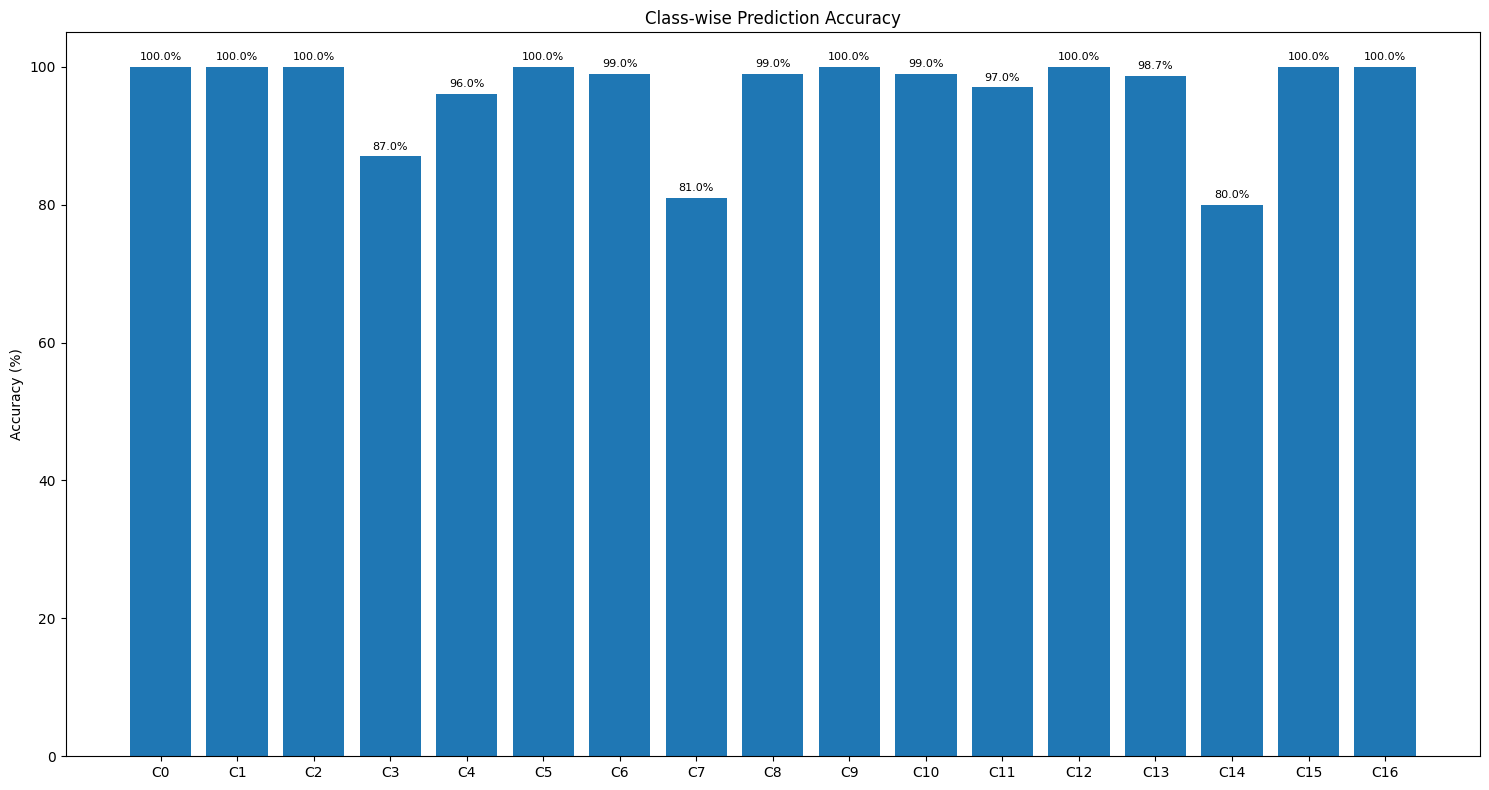

Worst 3 classes:
Class 14: 80.0%
Class 7: 81.0%
Class 3: 87.0%


In [13]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [14]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [15]:
# # load model
# model = timm.create_model(
#     model_name,
#     pretrained=True,
#     num_classes=17
# ).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=LR)

In [16]:
# for epoch in range(EPOCHS):
#     ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [17]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [18]:
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [19]:
# sample_submission_df = pd.read_csv("../data/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [20]:
# pred_df.to_csv("pred.csv", index=False)

In [21]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [22]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [23]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [24]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [25]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [26]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA:   0%|          | 0/50 [00:00<?, ?it/s]

Ensemble TTA: 100%|██████████| 50/50 [09:17<00:00, 11.15s/it]


In [27]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [28]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [29]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [30]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
